In [1]:
import torch

from pythae.models.base.base_config import BaseAEConfig
from torch.utils.data import DataLoader, random_split

In [2]:
from multivae.data.datasets import MnistSvhn

train_data = MnistSvhn(split="test", data_path="data")
train_data, eval_data = random_split(
    train_data, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)

Using downloaded and verified file: data/test_32x32.mat


## Building the model

In [3]:
from multivae.models import MVAEConfig

# Define the model configuration
model_config = MVAEConfig(
    n_modalities=2,
    input_dims=dict(mnist=(1, 28, 28), svhn=(3, 32, 32)), # we set the input dim for each modality
    latent_dim=20,
    use_likelihood_rescaling=True,
    k=0,
)

In [4]:
from multivae.models.nn.default_architectures import Decoder_AE_MLP, Encoder_VAE_MLP
from multivae.models.nn.svhn import Decoder_VAE_SVHN, Encoder_VAE_SVHN

# define a dictionary of encoders
encoders = dict(
    mnist=Encoder_VAE_MLP(BaseAEConfig(latent_dim=20, input_dim=(1, 28, 28))),
    svhn=Encoder_VAE_SVHN(BaseAEConfig(latent_dim=20, input_dim=(3, 32, 32))),
)

# define a dictionary of decoders
decoders = dict(
    mnist=Decoder_AE_MLP(BaseAEConfig(latent_dim=20, input_dim=(1, 28, 28))),
    svhn=Decoder_VAE_SVHN(BaseAEConfig(latent_dim=20, input_dim=(3, 32, 32))),
)

In [5]:
from multivae.models import MVAE

# We can now build the model using the model configuration and the encoders/decoders
model = MVAE(model_config, encoders, decoders)

## Launching a training

In [6]:
from multivae.trainers import BaseTrainerConfig

# Define the training configuration
trainer_config = BaseTrainerConfig(
    output_dir="trained_models",
    num_epochs=1,
    learning_rate=1e-4,
    steps_predict=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

/home/clement/anaconda3/envs/multivae/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from multivae.trainers import BaseTrainer

# Build the trainer
trainer = BaseTrainer(
    model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    training_config=trainer_config
)

Model passed sanity check !
Ready for training.



In [8]:
# Launch training
trainer.train()

Created trained_models folder since did not exist.

Created trained_models/MVAE_training_2023-03-21_16-13-26. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 1
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Eval of epoch 1/1: 100%|██████████| 157/157 [00:10<00:00, 15.09batch/s]
--------------------------------------------------------------------------
Train loss: 303.1896
Eval loss: 189.9672
--------------------------------------------------------------------------
Training ended!
Saved final model in trained_models/MVAE_training_2023-03-21_16-13-26/final_model


## Reloading the trained model

In [9]:
import os
from multivae.models import AutoModel

last_training = sorted(os.listdir('trained_models'))[-1]
trained_model = AutoModel.load_from_folder(os.path.join('trained_models', last_training, 'final_model'))

In [33]:
svhn_from_mnist = trained_model.predict(
    train_data[:10],
    "mnist",
    "svhn"
).svhn.detach().cpu()

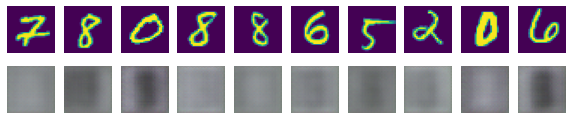

In [47]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(10, 2))

for i in range(len(svhn_from_mnist)):
    ax[0][i].imshow(np.moveaxis(train_data[:10].data['mnist'][i].numpy(), 0, 2))
    ax[0][i].axis('off')
    ax[1][i].imshow(np.moveaxis(svhn_from_mnist[i].numpy(), 0, 2))
    ax[1][i].axis('off')